In [1]:
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import lightgbm as lgb
import math

from cpcv_util import *

In [2]:
# 真値と予測値を比較して表示するためのユーティリティ関数
def display_true_vs_pred(series_true, series_pred, subtitle):
    df = pd.DataFrame({'true': series_true, 'pred': series_pred}).dropna()
    corr = np.corrcoef(df['true'], df['pred'])
    pred_std = df['pred'].std()
    pred_mean = df['pred'].mean()
    true_std = df['true'].std()
    true_mean = df['true'].mean()
    
    pred_max = pred_mean + 4*pred_std
    pred_min = pred_mean - 4*pred_std
    true_max = true_mean + 4*true_std
    true_min = true_mean - 4*true_std
    
    fig, ax = plt.subplots(2, 2, sharex='col', sharey = 'row',
                           gridspec_kw={'width_ratios': [2, 0.5], 'height_ratios': [2, 0.5]}, figsize=(6, 6))
    
    # 予測値のレンジごとに真値の平均をプロットして比例関係があることを確認する
    pred_sections = []
    true_means = []
    for i in range(17):
        _df = df[(df['pred'] >= pred_min + 0.5 * pred_std * i) & (df['pred'] < pred_min + 0.5 * pred_std * (i + 1))]
        pred_sections.append(pred_min + 0.5 * pred_std * i)
        true_means.append(_df['true'].mean())
    
    # 散布図をプロットする (予測対象にならなかったtrue値は0になっているのでそれを除外していることに注意)
    #ax[0, 0].scatter(df.loc[df['true'] != 0,'pred'], df.loc[df['true'] != 0, 'true'], s = 1)
    ax[0, 0].scatter(df['pred'], df['true'], s = 1)
    ax[0, 0].step(pred_sections, true_means, 'red', where='post')
    ax[0, 0].set_title(subtitle + f' (IC={corr[0][1]:0.4f})')
    ax[0, 0].set_xlabel("prediction")
    ax[0, 0].set_ylabel("truth")
    ax[0, 0].set_xlim([pred_min, pred_max])
    ax[0, 0].set_ylim([true_min, true_max])
    ax[0, 0].set_xticks([pred_mean, pred_mean - 2*pred_std, pred_mean - 4*pred_std, pred_mean + 2*pred_std, pred_mean + 4*pred_std])
    ax[0, 0].set_yticks([true_mean, true_mean - 2*true_std, true_mean - 4*true_std, true_mean + 2*true_std, true_mean + 4*true_std])
    ax[0, 0].grid(axis = 'both')
    ax[0, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    ax[0, 0].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    # 0と予測した値を表示するとヒストグラムがまともに見えないので除外している
    ax[1, 0].hist(df.loc[df['true'] != 0, 'pred'], bins=50, range=[pred_min, pred_max])
    ax[1, 0].grid(axis = 'both')
    ax[1, 0].axvline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[0, 1].hist(df.loc[df['true'] != 0, 'true'], bins=50, orientation='horizontal', range=[true_min, true_max])
    ax[0, 1].grid(axis = 'both')
    ax[0, 1].axhline(0, color='red', linestyle='dotted', linewidth=1)
    
    ax[1, 1].remove()
    
    fig.show()

In [3]:
import optuna
import optuna.integration.lightgbm as lgb_optuna

# LightGBM単体のCVとOptunaを使ったCVを手軽に使い分けるためのユーティリティクラス
class LightGBMRegressionUtil:
    # デフォルトのLightGBM用パラメータ
    DEFAULT_LGBM_PARAMS = {
        'objective':'regression',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'extra_trees': True,
        'deterministic': True,
        'force_row_wise': True,
        'num_threads': 8
    }
    
    def __init__(self):
        self.cvbooster = None
        return
    
    def train_cv(self, df_train = None, df_target = None, folds = None, use_optuna = False, **params):
        if len(params) == 0:
            self.params = self.DEFAULT_LGBM_PARAMS
        
        # データセットを作成        
        lgb_train_data = lgb.Dataset(df_train, df_target, free_raw_data=False)
        
        if use_optuna == True:
            tuner = optuna.integration.LightGBMTunerCV(self.params,
                                                            train_set = lgb_train_data,
                                                            folds = folds,
                                                            early_stopping_rounds = 100,
                                                            verbose_eval = 0,
                                                            show_progress_bar = False,
                                                            optuna_seed = 47,
                                                            return_cvbooster = True)
            tuner.run()
            self.cvbooster = tuner.get_best_booster()
        else:
            _eval_hist = lgb.cv(self.params,
                                train_set = lgb_train_data,
                                folds = folds,
                                early_stopping_rounds = 100,
                                verbose_eval = 0,
                                return_cvbooster = True)
            self.cvbooster = _eval_hist['cvbooster']
    
    def predict(self, df = None, folds = None, predict_training = False):
        df_predict = pd.DataFrame(self.cvbooster.predict(df, num_iteration=self.cvbooster.best_iteration))
        df_predict = df_predict.transpose()
        df_predict.index = df.index
        
        # foldsが与えられた場合、与えられたdfが学習時に使ったものと同一と仮定し、必要のないセクションの予測値をnanで上書きする
        if folds is not None:
            for index, fold in enumerate(folds):
                if predict_training == True:
                    df_predict.iloc[fold[1], index] = np.nan
                else:
                    df_predict.iloc[fold[0], index] = np.nan
        
        return df_predict.mean(axis=1) # 残った予測値を使って平均値を計算する

,x,y,y_noise
0,5.415923,-0.762560,-1.051273
1,-4.924724,0.977542,0.871395
2,5.957277,-0.320169,-0.451749
3,4.134942,-0.837859,-0.743676
4,0.026196,0.026193,0.301718
...,...,...,...
9995,2.544777,0.562011,0.630025
9996,-3.669041,0.503330,0.519887
9997,-1.537584,-0.999449,-0.764446
9998,-5.448460,0.741112,0.485147


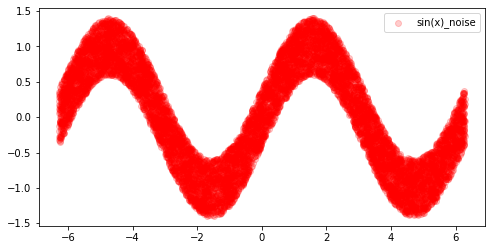

In [4]:
sample_size = 10000
#x = np.linspace(-10, 10, sample_size)
x = [random.uniform(-2 * math.pi, 2 * math.pi) for x in range(sample_size)]
y = np.sin(x)
y_noise = y + np.random.uniform(-0.4, 0.4, sample_size)

df = pd.DataFrame({'x': x, 'y': y, 'y_noise': y_noise})

plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='sin(x)_noise', color='red', alpha=0.2)
plt.legend()

display(df)

In [5]:
lgb_util = LightGBMRegressionUtil()

# Optunaを使わないシンプルなregression予測を行い、トレーニング区間を予測する
folds = cpcv_split(df)
lgb_util.train_cv(df[['x']], df['y_noise'], folds, use_optuna = False)
df['y_pred'] = lgb_util.predict(df[['x']], folds, predict_training = True)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


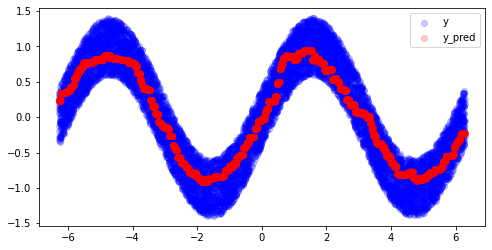

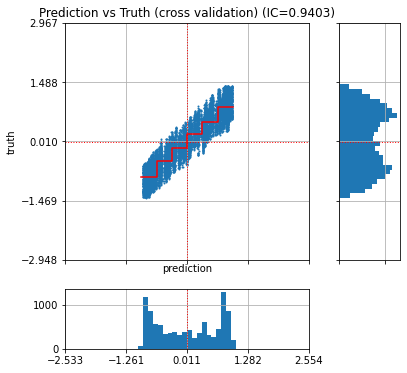

In [6]:
# 学習結果の表示
plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='y', alpha=.2, color='blue')
plt.scatter(df['x'], df['y_pred'], label='y_pred', alpha=.2, color='red')
plt.legend()

# 真値と予測値の関係を見る
display_true_vs_pred(df['y_noise'], df['y_pred'], 'Prediction vs Truth (cross validation)')

In [7]:
# Optunaを使わないシンプルなregression予測を行い、バリデーション区間を予測する
folds = cpcv_split(df)
lgb_util.train_cv(df[['x']], df['y_noise'], folds, use_optuna = False)
df['y_pred'] = lgb_util.predict(df[['x']], folds)

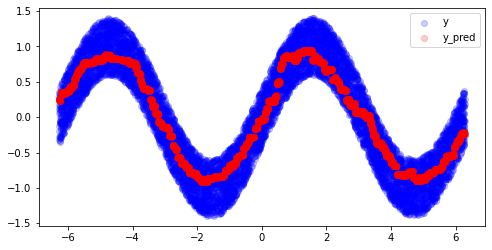

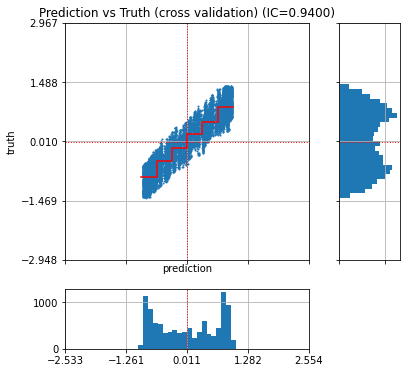

In [8]:
# 学習結果の表示
plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='y', alpha=.2, color='blue')
plt.scatter(df['x'], df['y_pred'], label='y_pred', alpha=.2, color='red')
plt.legend()

# 真値と予測値の関係を見る
display_true_vs_pred(df['y_noise'], df['y_pred'], 'Prediction vs Truth (cross validation)')

In [9]:
# Optunaを使ってregression予測を行い、トレーニング区間を予測する
folds = cpcv_split(df)
lgb_util.train_cv(df[['x']], df['y_noise'], folds, use_optuna = True)
df['y_pred'] = lgb_util.predict(df[['x']], folds, predict_training = True)

[I 2022-02-09 17:02:12,678] A new study created in memory with name: no-name-133228e4-e475-4045-94b5-f1de31f393e2
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
[I 2022-02-09 17:02:16,181] Trial 0 finished with value: 0.23336859052493572 and parameters: {'feature_fraction': 0.4}. Best is trial 0 with value: 0.23336859052493572.
/opt/conda/li

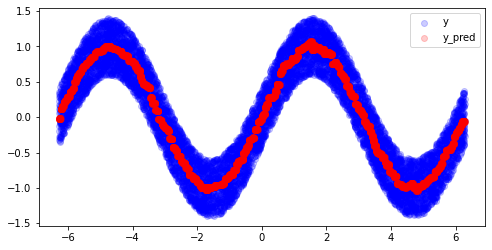

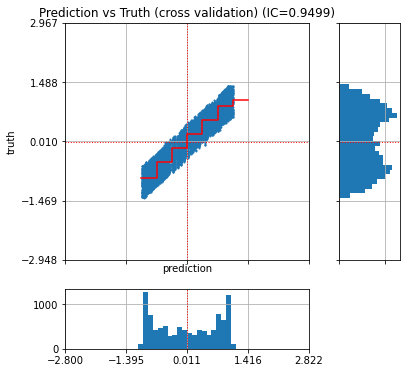

In [10]:
# 学習結果の表示
plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='y', alpha=.2, color='blue')
plt.scatter(df['x'], df['y_pred'], label='y_pred', alpha=.2, color='red')
plt.legend()

# 真値と予測値の関係を見る
display_true_vs_pred(df['y_noise'], df['y_pred'], 'Prediction vs Truth (cross validation)')

In [11]:
# Optunaで作った予測器をそのまま利用して、バリデーション区間を予測
df['y_pred'] = lgb_util.predict(df[['x']], folds)

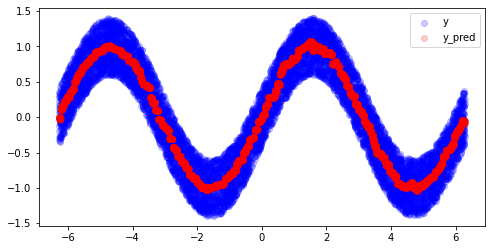

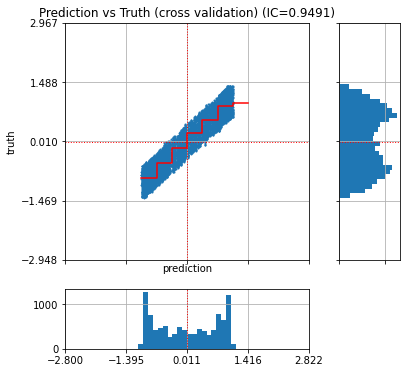

In [12]:
# 学習結果の表示
plt.figure(figsize=[8, 4])
plt.scatter(df['x'], df['y_noise'], label='y', alpha=.2, color='blue')
plt.scatter(df['x'], df['y_pred'], label='y_pred', alpha=.2, color='red')
plt.legend()

# 真値と予測値の関係を見る
display_true_vs_pred(df['y_noise'], df['y_pred'], 'Prediction vs Truth (cross validation)')

In [13]:
# このテストコードにテスト区間はない